In [3]:
%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(16, 4.2)

from util import util_taxi as util # Import our submodule
import pandas as pd
import numpy as np
import os

data_folder = os.path.join('..', 'data', 'nab')
file_name = os.path.join('realKnownCause', 'nyc_taxi.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Anomaly Detection in Taxi Calls

Problem and Data


## Anomaly Detection on Taxi Calls

**Let's considere a Taxi company:**

<center><img src="assets/sized-yellow-taxi.jpg" width="60%"/></center>

## Anomaly Detection on Taxi Calls

**Some context information:**

* There's historical data about taxi calls in NYC (number of taxi calls over time)
* A major decision for the company is choosing the size of the car pool
* This depends on how many calls are expected
* Strong deviations from the usual patterns may also cause issues
* The company is mostly interested in _detecting such "anomalies"_
* Anticipating them would be a welcome addition, but it is not essential

> **How can we tackle this problem?**

## Getting Started

**A couple of good ideas:**

Trying to _understand the context_:

* The company priorities and how their business works
* Any expectation on the data
* ...

...And also _inspecting the data_

* ...So that we get a "feel" of how it works
* Formally: until we understand better its _statistical distribution_

**Doing both these things _early_ is always a good idea**

## A Look at the Data

**Let's have a look at the available data**

In [4]:
data, labels, windows = util.load_series(file_name, data_folder)
data.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


* `data` is a pandas `DataFrame` object
* It is essentially a _table_, in this case representing a _time series_
* There are well defined _column names_ (here "value")
* There is a well defined row _index_ (here "timestamp")


## A Look at the Data

**Time series are quite easy to visualize**

The most direct approach is using a Cartesian plot

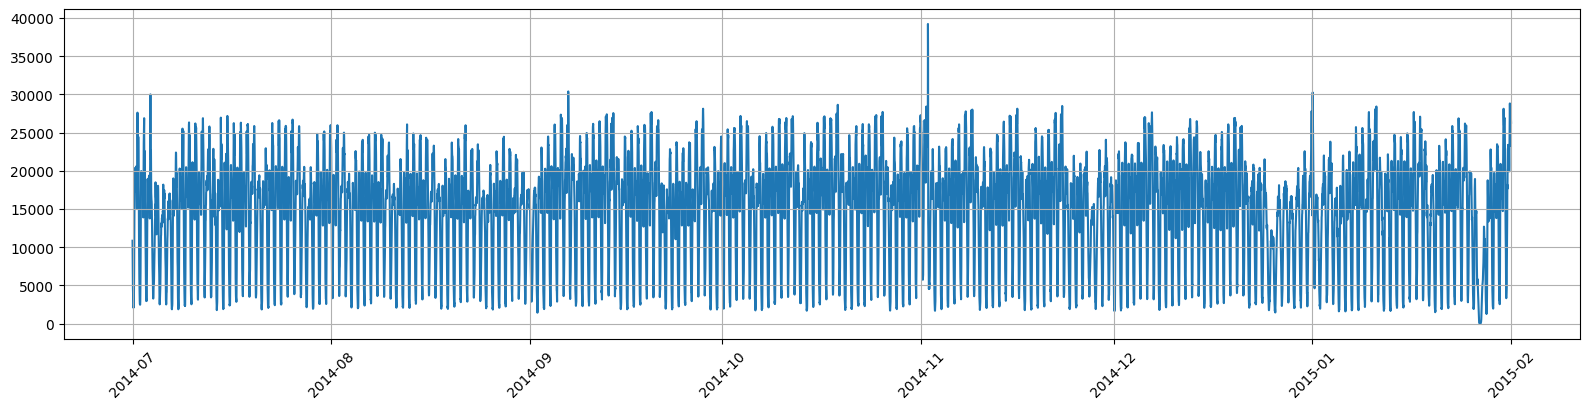

In [5]:
util.plot_series(data, figsize=figsize)

* If are curious, all use case code is available as part of the course material

## A Look at the Data

**We can now move to other data structures**

In [6]:
labels.head()

0   2014-11-01 19:00:00
1   2014-11-27 15:30:00
2   2014-12-25 15:00:00
3   2015-01-01 01:00:00
4   2015-01-27 00:00:00
dtype: datetime64[ns]

`labels` is a pandas `Series` object

* You can think of that as a one-column table

**This series contains the _timestamp of all known anomalies_**

* There are just a few of them
* ...and they are all hand-labeled

## A Look at the Data

**We can plot the call and anomalies together**

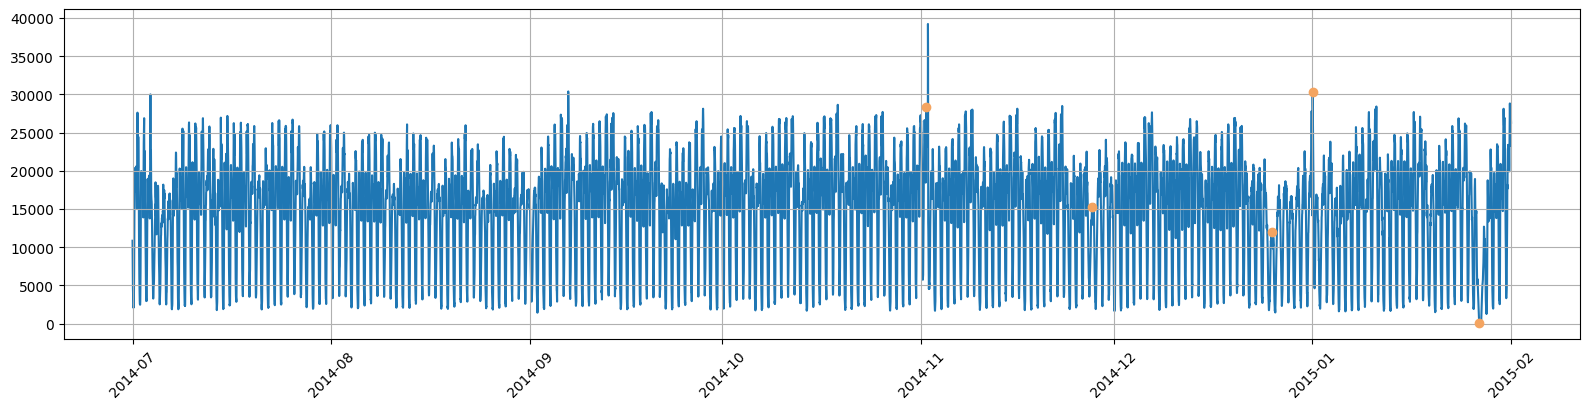

In [7]:
util.plot_series(data, labels, figsize=figsize)

* Most anomalies in the second part of the series
* ...But that's just a coincidence

## A Look at the Data

**Now we can check the "windows" data structure**

In [8]:
windows.head()

,begin,end
0,2014-10-30 15:30:00,2014-11-03 22:30:00
1,2014-11-25 12:00:00,2014-11-29 19:00:00
2,2014-12-23 11:30:00,2014-12-27 18:30:00
3,2014-12-29 21:30:00,2015-01-03 04:30:00
4,2015-01-24 20:30:00,2015-01-29 03:30:00


`windows` is another a pandas `DataFrame` object (a table)

* It contains the start/end of windows containing anomalies
* Detections within the window are useful and count as "hits"
* Detections outside the windows are false alarms

## A Look at the Data

**Let's plot all the information together**

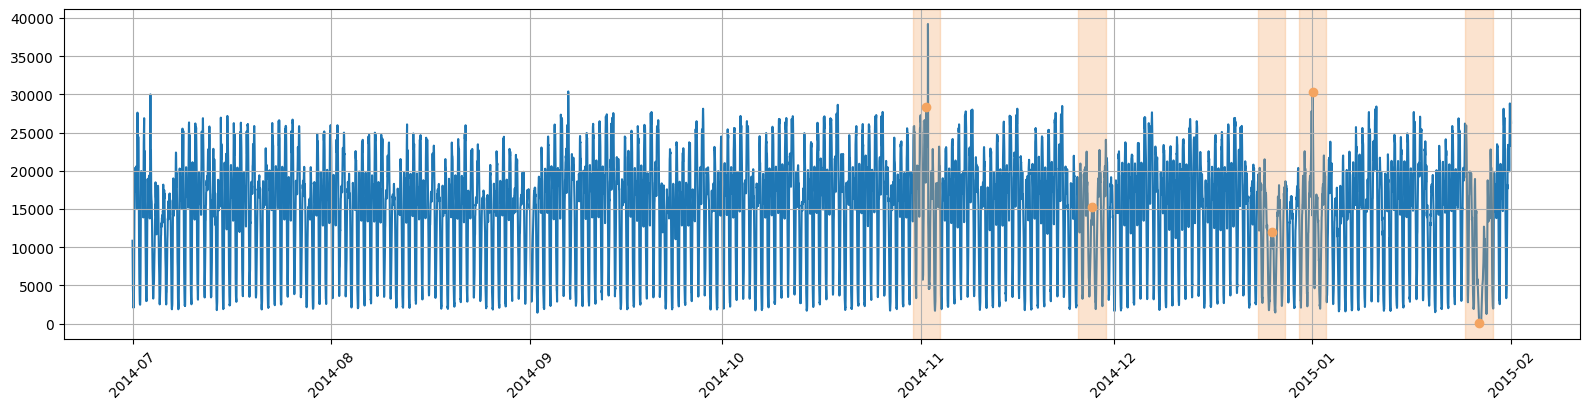

In [9]:
util.plot_series(data, labels, windows, figsize=figsize)

* Detections that occur too early/late count as misses 

# Anomaly Detection in Taxi Calls

Formalizing the Problem

<div class=big>
    <small>Let's start with a question</small><br>
What is our biggest difficulty right now?
</div>

## On the Importance of Formalization

**Right now, the problem we are tackling is _too vaguely defined_**

This makes it _much harder_ to think about:

* Solution approaches
* Evaluation procedures
* Key Performance Indicators

**Eventually, we'll need to formally specify:**

* The input and output of our solution system
* ...And a set of quality metrics

**But first, we need a formal way just to _reason_ on the system**

## System Formalization

**Let's attempt to formalize _the system_, first**

We can view the number of taxi call as _a random variable_

$$
X \sim P(X)
$$

* $X$ is a source of random data
* $D(X)$ is its support, i.e. the set of possible outcomes
* $P(X)$ is its distribution, i.e. the probability of every outcome

> **Can we use this to define our car pool size, or to detect anomalies?**

## Anomaly Detection and Car Pool Sizing

**Formally, we could size the car pool via a rule like**

$$
\mathop{\rm argmin}_{q \in D(X)} F(q) \geq \alpha
$$

* $F(x)$ tells use the probability that $X \leq x$ (Cumulative Distribution Function)
* $\alpha$ is the total probability of the scenario we want to cover with our pool

**...And we could detect anomalies via a rule like:**

$$
P(x) \leq \varepsilon
$$

* $\varepsilon$ is a threshold value
* If the probability of observing $x$ call is below $\theta$, we say we have an anomaly

<div class="big">
<small>We've already made good progress!</small><br>
What do we need to use this idea in practice?
</div>

## Density Estimation

**The main issue we have now is that we really don't know $P(X)$**

...But we can _learn it_ from our data

* Given a dataset $\{x_i\}_{i=1}^m$ containing observed numbers of taxi calls
* ...We can try to approximate $P(X)$ with a parametric function $\hat{f}(x; \theta)$

**This is the gist of _density estimation_**

In practice, $\hat{f}(x; \theta)$ is often trained for _maximum likelihood estimation_

* This is a very common training method based on the idea that a good model
* ...Should assign a high-probability to real data

## MLE Training

**Formally, MLE training consists in solving:**

$$
\mathop{\rm argmax}_{\theta} \prod_{i=1}^m \hat{f}(x_i; \theta)
$$

* Given our dataset $\{x_i\}_{i=1}^m$...
* ...We choose the model parameters $\theta$...
* ...So that the estimated probability is as high as possible

**Now we need to define two things:**

* Which data we should use for training
* Which function (i.e. model) to use as an estimator

# Anomaly Detection in Taxi Calls

### Data and Model

## Training and Testing

**We will split our data in two segments**

A _training set_, used for learning the estimator:

* This will include only data about the _normal_ behavior
* Ideally, there should be no anomalies here (we do not want to learn them!)

A _test set_, use for evaluation

* We should never optimize _anything_ on this

**If the training set contains some anomalies**

* Things are still mostly fine!
* ...As long as they are very _infrequent_

## Training and Testing

**In time series data sets are often split chronologically:**

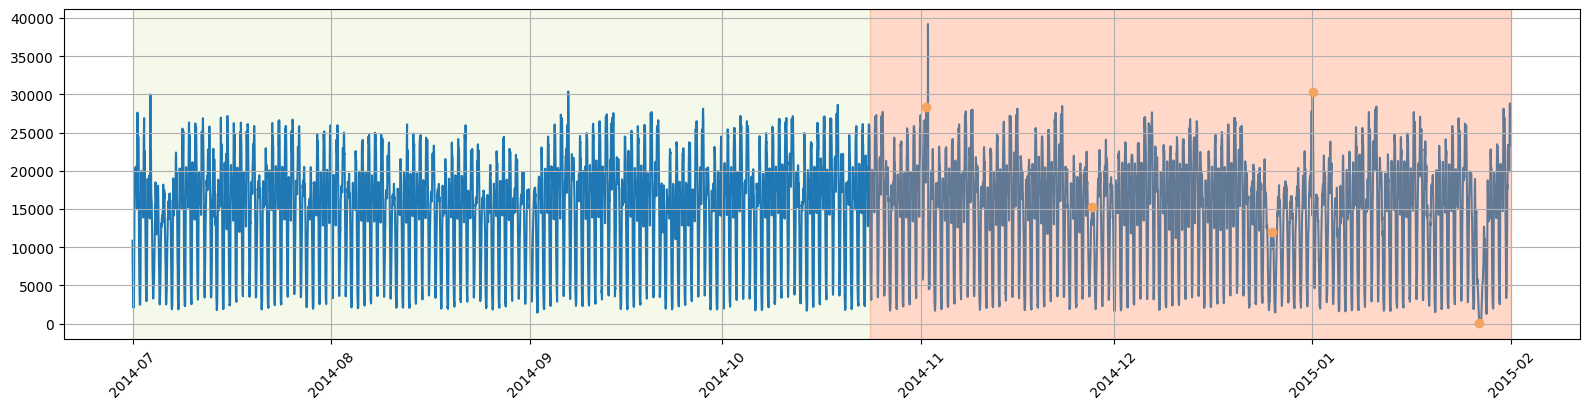

In [10]:
train_end = pd.to_datetime('2014-10-24 00:00:00')
util.plot_series(data, labels, test_start=train_end, figsize=figsize)

* Green: training set, orange: test set

## Choosing an Estimator

**Which estimation model should we use?**

* Lacking any strong reason for doing otherwise
* Using Occam's razor is usually a good idea

**So, we'll go for _a simple approach_**

<center><img src="assets/occams_razor.gif" width="70%"></center>

## Histograms as Density Estimators

**A histogram is a (very) simple density estimator**

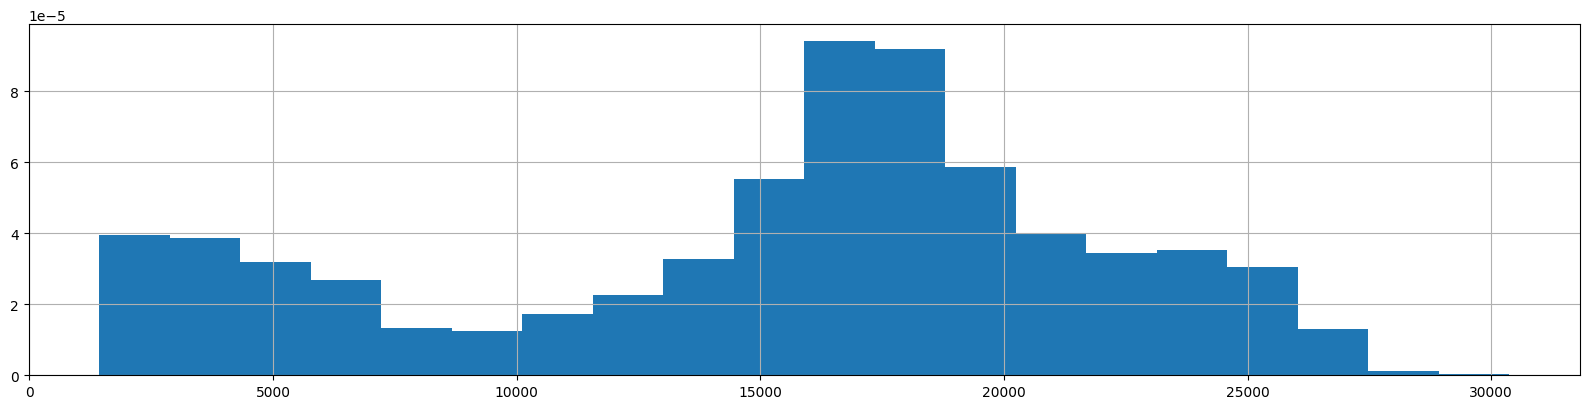

In [11]:
data_tr = data[data.index < train_end]
util.plot_histogram(data_tr, bins=20, figsize=figsize)

* It gives us a probability for every value
* The model parameters $\theta$ are in this case the bins

## Kernel Density Estimation

**Another simple approach is _Kernel Density Estimation_**

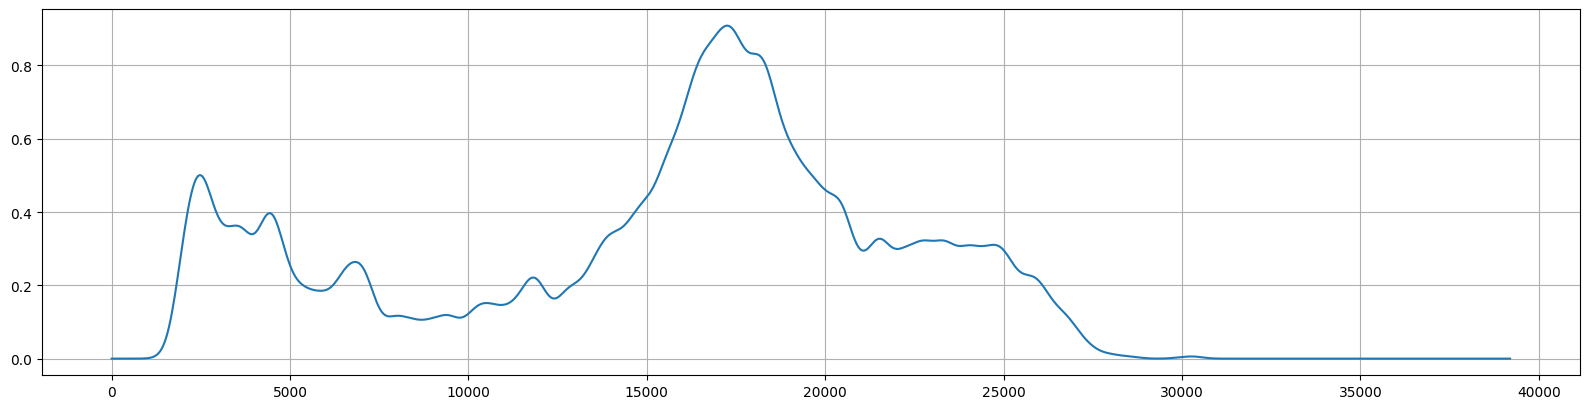

In [12]:
kde = util.train_kde(data_tr, bandwidth_range=np.linspace(0.01, 0.1, 10))
util.plot_density_estimator_1D(kde, np.linspace(0, data['value'].max(), 1000), figsize=figsize)

* KDE plances one small kernel (e.g. a Gaussian) on every training point
* A distribution is the obtained by averaging 

## Density Estimation for Anomaly Detection

**We can test our idea by checking the probability of anomalous points**

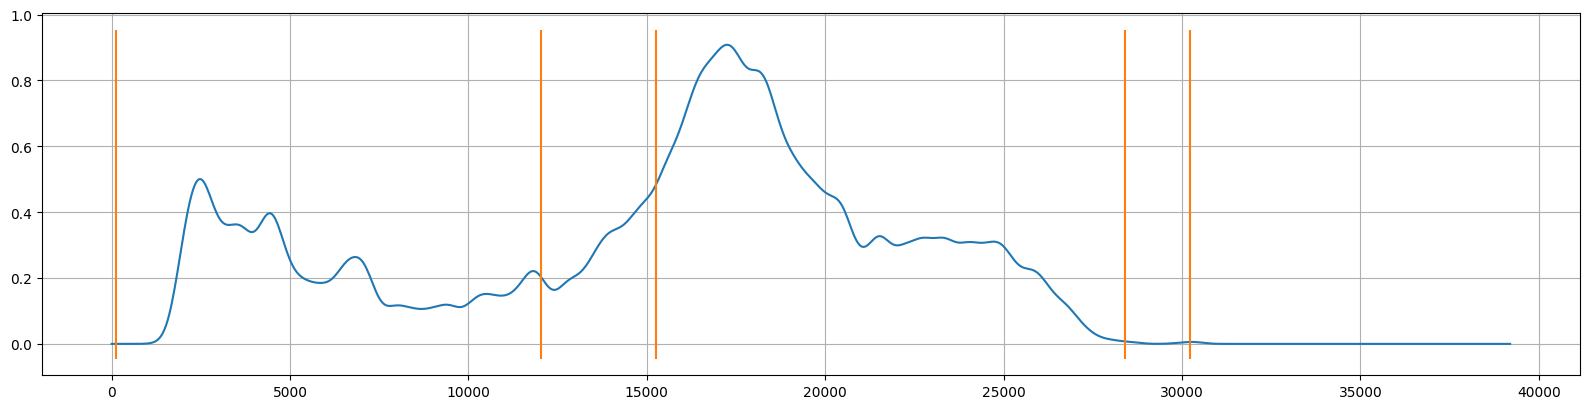

In [13]:
util.plot_density_estimator_1D(kde, np.linspace(0, data['value'].max(), 1000), figsize=figsize, highlight_values=data.loc[labels]['value'])

* Several of the anomalous points have very low estimated probabilities

## Alarm Signal

**In anomaly detection, it is actually customary to work with _alarm signals_**

* Rather than checking for low probabilities
* ...We check for a high "alarm"

**We can obtain an alarm signal from our estimator as:**

$$
-\log \hat{f}(x; \theta) \geq \varepsilon
$$

* We use log probabilities (to reduce a bit the scale)
* ...And we change the sign to interpret them as an "alarm"

It is still equivalent to the previous formulation

## Alarm Signal

**We can now obtain (and plot) our _alarm signal_:**

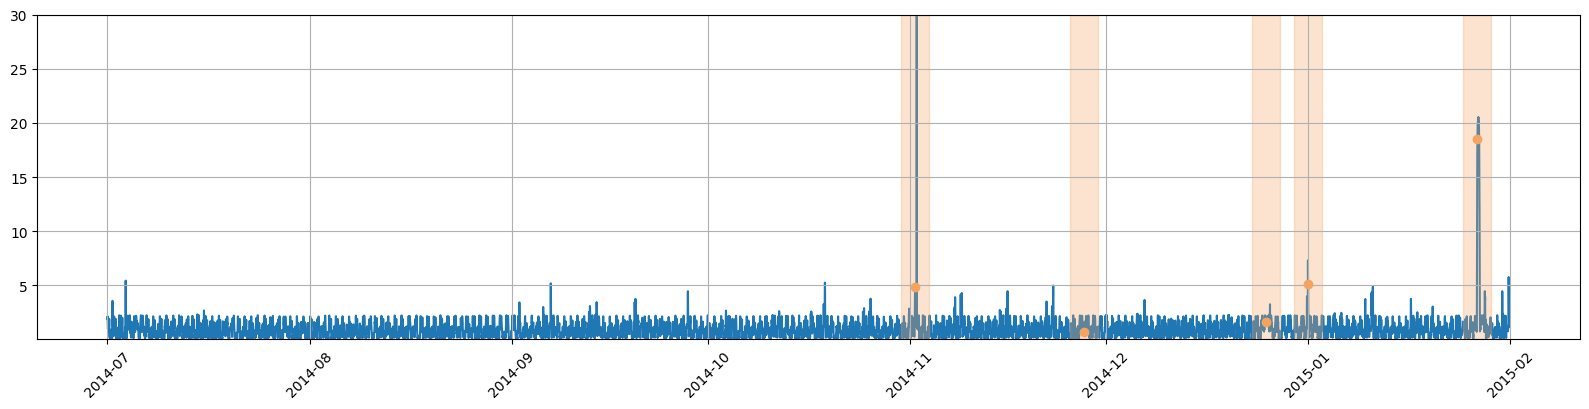

In [14]:
ldens = kde.score_samples(data.values) # Obtain log probabilities
signal = pd.Series(index=data.index, data=-ldens) # Build series with neg. prob.
util.plot_series(signal, labels=labels, windows=windows, figsize=figsize, y_cap=30) # Plot

* Again, some anomalies stand out

## Detecting Anomalies

**By picking a threshold, we can simulate the operation of our anomaly detector**

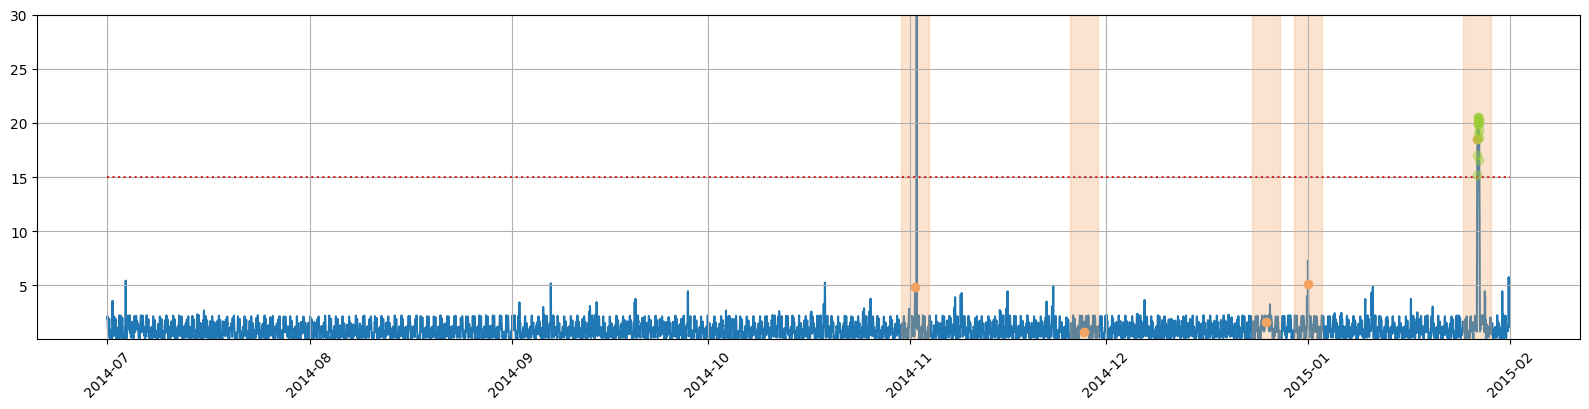

In [15]:
eps = 15
pred = pd.Series(signal.index[signal >= eps]) # the threshold il 12
util.plot_series(signal, labels=labels, windows=windows, predictions=pred, threshold=eps, figsize=figsize, y_cap=30)

* Not very good, but the threshold is chosen almost at random now
* There are a many false positives, which are _very common_ in anomaly detection

# Anomaly Detection in Taxi Calls

### Metrics and Threshold Choice

<div class=big>
<small>For choosing a threshold, we need to determine its quality</small><br>
...But how do we evaluate a system like this?
</div>

## Metrics for Anomaly Detection

**Evaluating the quality of an Anomaly Detection system can be tricky**

* Usually, we do not need to match the anomalies exactly
* Sometimes we wish to anticipate anomalies
* ...But sometimes we just want to detect them in past data

There is no "catch-all" metric, like accuracy in classification

**It is much better to devise a _cost model_**

* We evaluate the cost and benefits of our predictions:
* By doing this, we focus on _the value for our customer_

> **This is important _for all industrial problems!_**


## A Simple Cost Model

**We will use a simple cost model**

Remember that our goals are:

* Analyzing anomalies
* Anticipating anomalies

**We will use a simple model based on:**

* _True Positives_ as windows for which we detect at least one anomaly
* _False Positives_ as detected anomalies that do not fall in any window
* _False negatives_ as anomalies that go undetected
* _Late detections_ as windows where a detection was correct, but late

## A Simple Cost Model

**In our example, we'll assign a somewhat arbitrary cost to every error**

In [16]:
c_alrm = 1 # Cost of investigating a false alarm
c_missed = 10 # Cost of missing an anomaly
c_late = 5 # Cost for late detection
cmodel = util.ADSimpleCostModel(c_alrm, c_missed, c_late)
cost = cmodel.cost(signal, labels, windows, thr=3.5)
print(f'The cost with the current predictions is: {cost}')

The cost with the current predictions is: 56


**This is just an example, but the idea of focusing on acutal cost is important**

In general, our goal is to find some kind of _cost function_ $c(\{x_i\}_{i=1}^m, \theta, \varepsilon)$ depending on:

* An evaluation dataset $\{x_{i=1}\}^m$
* The estimator parameters $\theta$
* The threshold $\varepsilon$

## Choosing the Threshold

**Ideally, we wish to choose _the best threshold_**

For that, we need a dataset to evaluate $c(\{x_i\}_{i=1}^m, \theta, \varepsilon)$

* ...But we _cannot_ use the test data!
* ...Since that would lead to overfitting

**Most data-driven AI approaches have both parameters and hyper-parameters**

* In our case, $\theta$ represents the parameter
* ...And $\varepsilon$ is a hyper-parameter

Neither should be optimized on the test data

## Define a Validation Set

**We can however define a separate _validation set_**

We need a fraction of the data containing anomalies

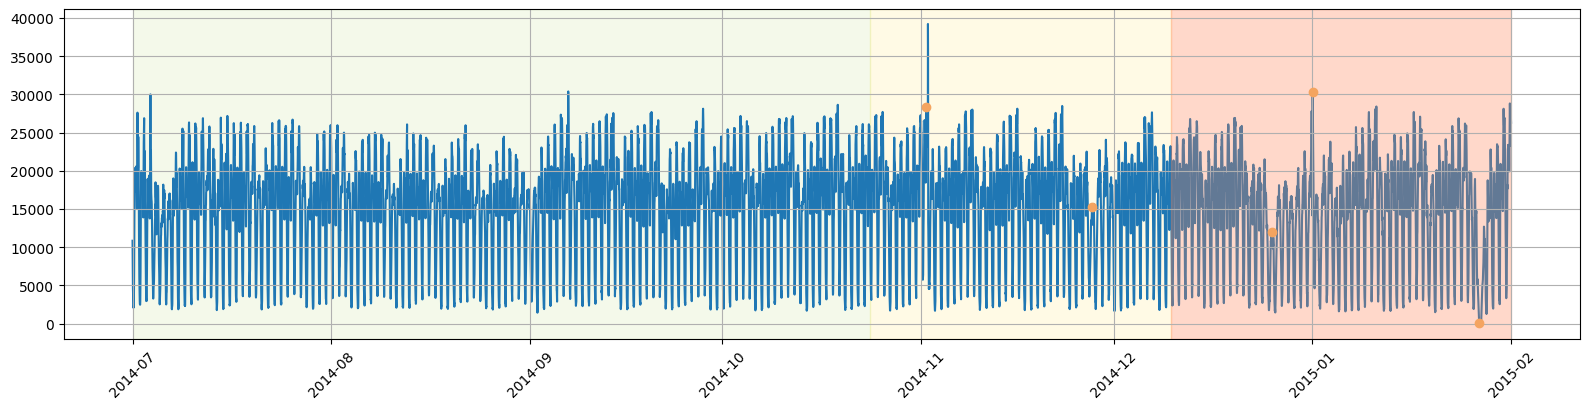

In [17]:
val_end = pd.to_datetime('2014-12-10 00:00:00')
util.plot_series(data, labels, val_start=train_end, test_start=val_end, figsize=figsize)

## Effect of Changing the Threshold

**We can visualize the cost associated to different thresholds on the validation set**

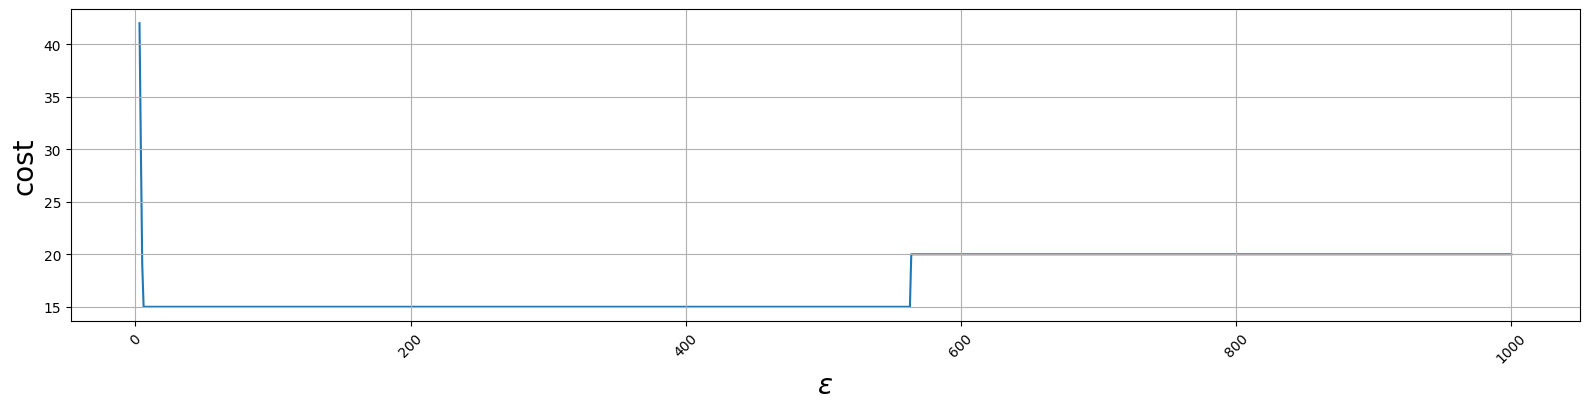

In [18]:
signal_opt = signal[signal.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]
thr_range = np.linspace(3, 1000, 1000)
cost_range = pd.Series(index=thr_range, data=[cmodel.cost(signal_opt, labels_opt, windows_opt, thr) for thr in thr_range])
util.plot_series(cost_range, figsize=figsize, xlabel=r'$\varepsilon$', ylabel='cost')

## Threshold Optimization

**We can now define our threshold $\varepsilon$ by optimizing over the validation set:**

$$
\mathop{\rm argmin}_{\varepsilon} c(\{x_i\}_{i=1}^m, \theta, \varepsilon)
$$

In [19]:
best_thr, best_cost = util.opt_thr(signal_opt, labels_opt, windows_opt,  cmodel, thr_range)
print(f'Best threshold: {best_thr:.3f}, corresponding cost: {best_cost:.3f}')

Best threshold: 5.994, corresponding cost: 15.000


Then we can check how our detector performed on the test data:

In [20]:
signal_test = signal[signal.index >= val_end]
labels_test = labels[labels >= val_end]
windows_test = windows[windows['begin'] >= val_end]
ctst = cmodel.cost(signal_test, labels_test, windows_test, best_thr)
print(f'Cost on the test data {ctst}')

Cost on the test data 10


# Anomaly Detection in Taxi Calls

### Improving the Results

## Reassess and Plan

**Let's recap our current situation**

* We have a formalization for our anomaly detector
* ...And one for threshold optimization

Which means that we have a _full problem formalization_

**We also have a simple prototype**

* KDE is used for density estimation
* Grid search for threshold optimization

> **Can we do better?**

## A Closer Look at Our Data

**Let's have a closer look at our series**

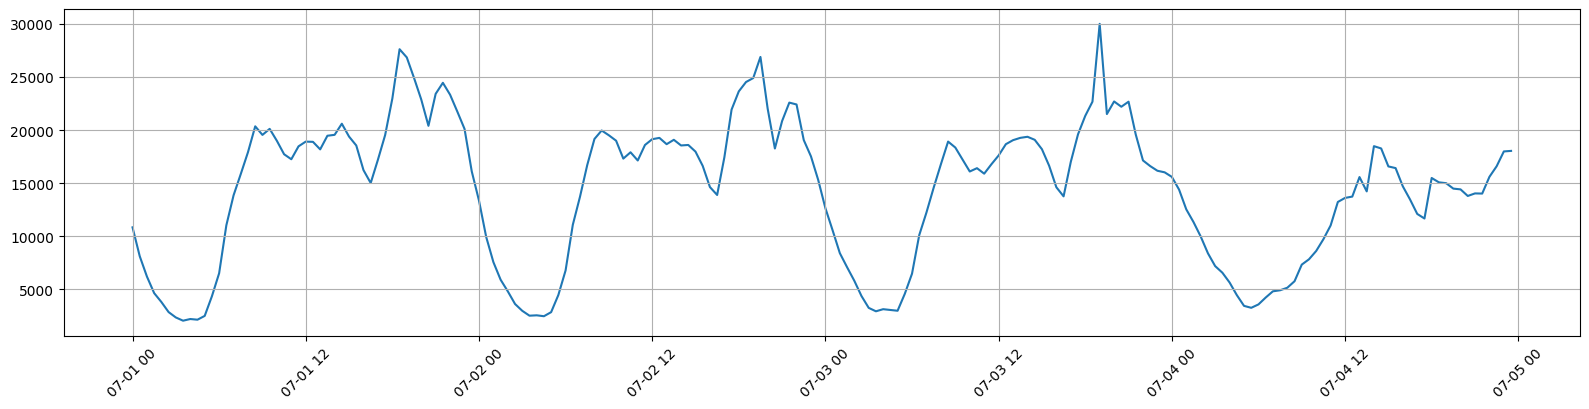

In [21]:
util.plot_series(data.iloc[:4*48], figsize=figsize)

* The number of calls seems to be roughly following _a period_
* Which is quite normal, given that it's a local, human, activity

## Determine the Period

**This is even clearer if we draw an _autocorrelation plot_**

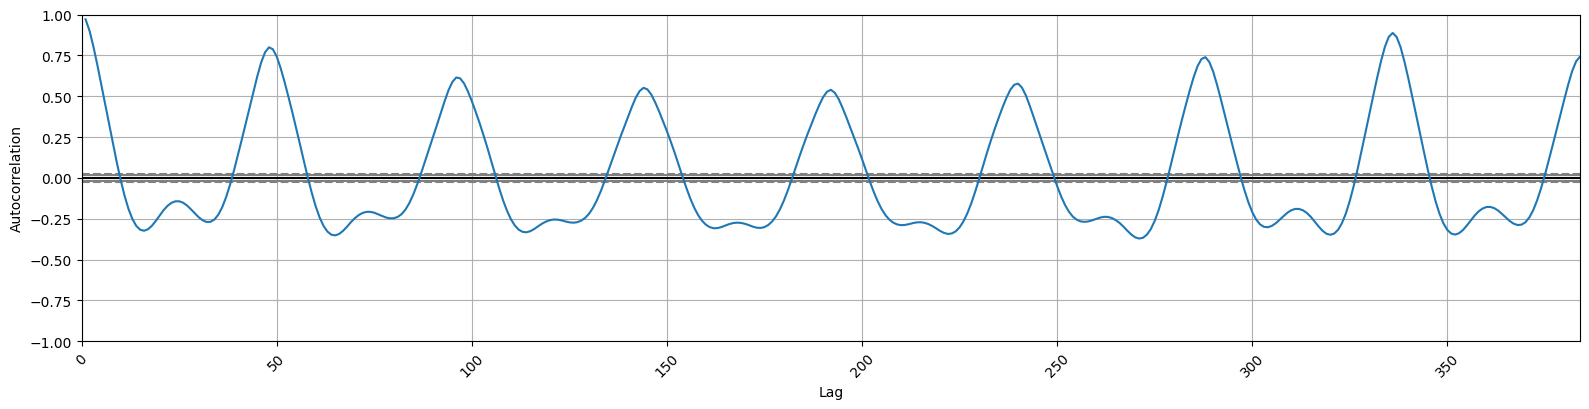

In [22]:
util.plot_autocorrelation(data, max_lag=8*48, figsize=figsize)

* There are _peaks every 48_ time steps (a time step is 30 minutes)
* And the peak at $7 \times 48$ steps (one week) is particuarly tall

## Time as an Additional Input

**One way to look at that**

...Is that the distribution _depends on the position within the period_

* Therefore, we should consider the number of taxi calls $x$
* ...And the time of the week $t$ together

**Let us extract (from the index) the time information information:**

In [23]:
hour_of_week = (24 * data.index.weekday + data.index.hour + data.index.minute / 60)

We can then add it as a separate column to the data:

In [24]:
data2 = data.copy()
data2['hour_of_week'] = hour_of_week

## Multivariate Distribution

**Let us examine the resulting _multivariate_ distribution**

We can use a 2D histogram:

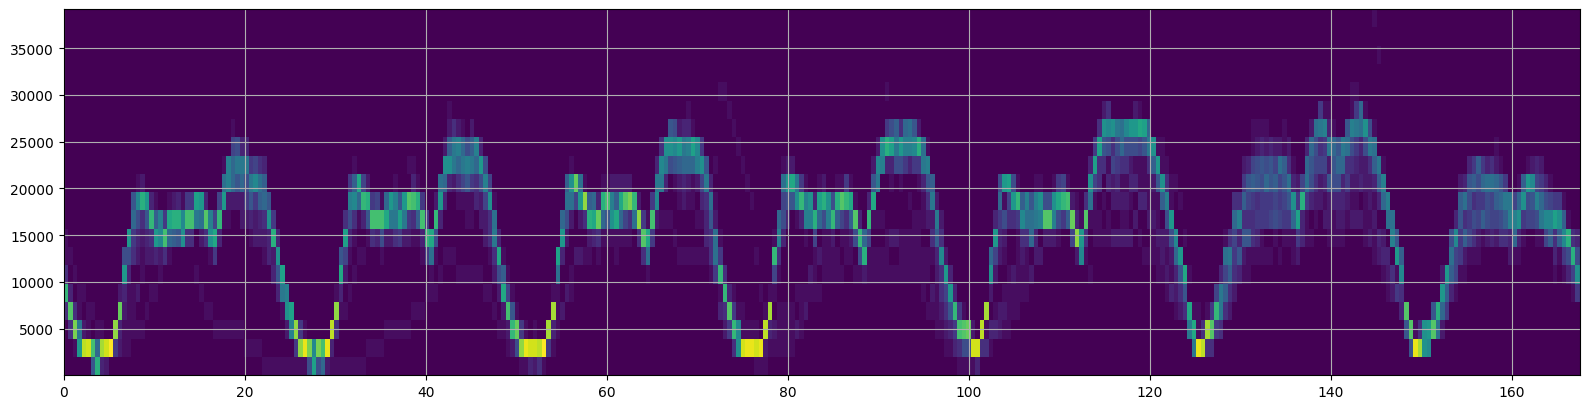

In [25]:
util.plot_histogram2d(data2['hour_of_week'], data2['value'], bins=(7*48, 20), figsize=figsize)

* x = time, y = value, color = frequency of occurrence

## Training a Density Estimator

**We can train a KDE model for this new dataset, too**

In [26]:
data2_tr = data2[data2.index < train_end]
kde2 = util.train_kde(data2_tr, bandwidth_range=np.linspace(0.01, 0.1, 10))

The model will now estimate a _joint_ distribution (calls & time):

$$
\hat{f}(X, T) \simeq P(X, T)
$$

We can use this model for anomaly detection just like in the previous case

$$
\hat{f}(X, T) \leq \varepsilon
$$

* In truth, things are bit more complicated, but we'll skip the details

## Alarm Signal

**We can obtain an alarm signal like in the previous case**

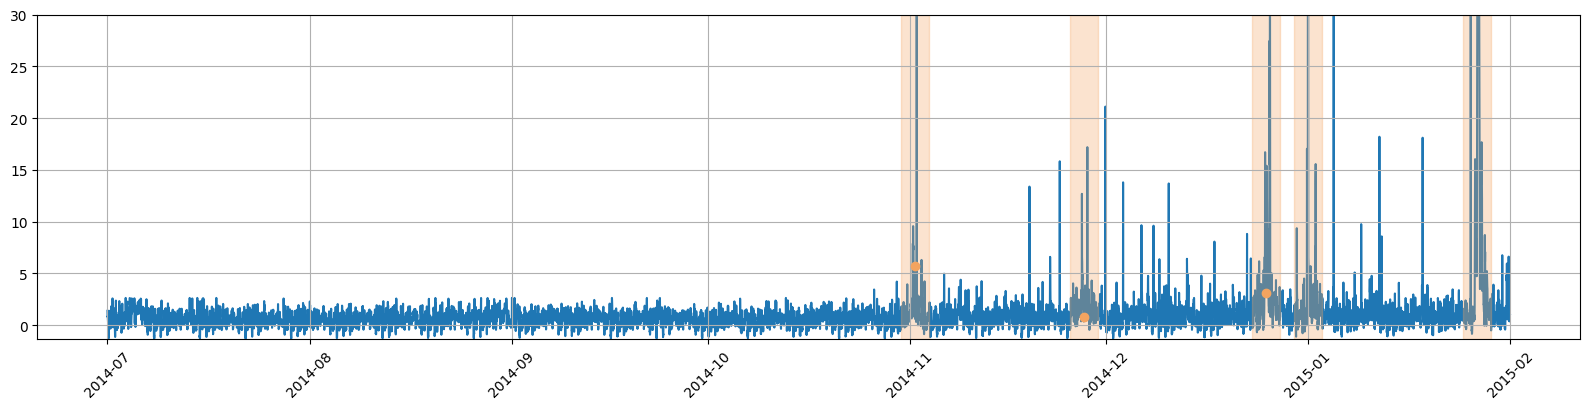

In [27]:
ldens2 = kde2.score_samples(data2.values) # Obtain log probabilities
signal2 = pd.Series(index=data2.index, data=-ldens2) # Build series with neg. prob.
util.plot_series(signal2, labels=labels, windows=windows, figsize=figsize, y_cap=30) # Plot

* There are not several peaks around some of the previously missed anomalies

## Threshold Selection

**The cost surface we get for $\varepsilon$ is also more varied**

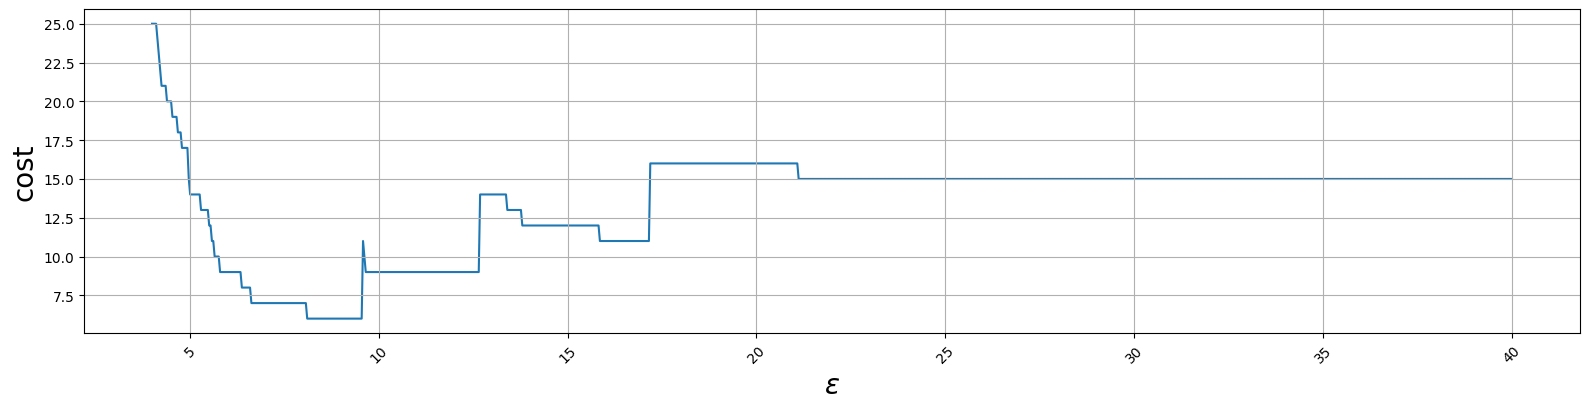

In [28]:
signal_opt2 = signal2[signal2.index < val_end]
thr_range2 = np.linspace(4, 40, 1000)
cost_range2 = pd.Series(index=thr_range2, data=[cmodel.cost(signal_opt2, labels_opt, windows_opt, thr) for thr in thr_range2])
util.plot_series(cost_range2, figsize=figsize, xlabel=r'$\varepsilon$', ylabel='cost')

## Evaluation

**Let's see which kind of costs we get for the new model**

We'll start from the training and validation data

* This is the data for which $\varepsilon$ is directly optimized
* So, improvement can be taken almost for granted here

In [29]:
best_thr2, best_cost2 = util.opt_thr(signal_opt2, labels_opt, windows_opt,  cmodel, thr_range2)
print(f'Best threshold: {best_thr:.3f}, corresponding cost: {best_cost2:.3f}')

Best threshold: 5.994, corresponding cost: 6.000


But we also get better results on the test data!

In [30]:
signal_test2 = signal2[signal2.index >= val_end]
ctst = cmodel.cost(signal_test2, labels_test, windows_test, best_thr2)
print(f'Cost on the test data {ctst}')

Cost on the test data 9
